In [40]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import zuko
import lampe.inference, lampe.utils
import matplotlib.pyplot as plt
import tqdm

In [41]:
N = 50000
sigma = 0.01
tau = 0.25
rho = 1/2
mu = 0

Utils

In [42]:
def generate_data(N, mu):
    
    sample = mu + torch.distributions.Normal(0, 1).sample((N, 100 ))
    x_raw = torch.cat((sample.mean(dim=1, keepdim=True), sample.std(dim=1, keepdim=True)), dim=1)
    
    y_raw = x_raw + torch.distributions.Normal(0, 1).sample(x_raw.shape)
    return x_raw, y_raw
    

In [43]:
prior_over_mu = torch.distributions.Normal(torch.zeros(1), torch.ones(1)*25)

In [44]:
def simulator(N_train,N_test, prior):
    N = N_train + N_test
    theta = prior.sample((N, ))
    
    sample = torch.distributions.Normal(theta.unsqueeze(1), 1.0).sample((100, ))
    
    x_raw = torch.cat((sample.mean(dim=0, keepdim=True), sample.std(dim=0, keepdim=True)), dim=2).squeeze_()
    theta, theta_test = theta.split(N_train)
    x_raw, x_raw_test = x_raw.split(N_train)
    return theta, theta_test, x_raw, x_raw_test

In [45]:
theta_raw, theta_test, x_raw, x_test_raw = simulator(N, N//10, prior_over_mu)
x_mean = x_raw.mean(0)
x_std = x_raw.std(0)

theta_mean = theta_raw.mean()
theta_std =  theta_raw.std()
x = (x_raw - x_raw.mean(0) ) / x_raw.std(0)
x_test = (x_test_raw - x_test_raw.mean(0) ) / x_test_raw.std(0)

theta = (theta_raw - theta_mean) / theta_std

In [46]:
dataset = lampe.data.JointDataset(theta, x)
dataset_test = lampe.data.JointDataset(theta_test, x_test)
_, y_raw = generate_data(N,mu)
y = (y_raw - y_raw.mean(0) ) / y_raw.std(0)

Simulation (line 1 & 2 of Algorithm 1)

In [47]:
def train_NPE(flow, data, loss,theta_test, x_test, learning_rate=5*10e-4, max_epochs=50,batch_size=256,patience=5):
    """Trains a NPE.

    Args:
        flow (lampe.inference.NPE): A instanciated flow
        data (lampe.data.JointDataset): dataset (theta, x)
        loss (callable): a loss function
        theta_test (torch.Tensor): test batch
        x_test (torch.Tensor): test batch
        learning_rate (float, optional): Defaults to 5*10e-4.
        max_epochs (int, optional): Defaults to 50.
        batch_size (int, optional): Defaults to 256.
        patience (int, optional): Defaults to 5.

    Returns:
        lampe.inference.NPE: the trained NPE
    """
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    step = lampe.utils.GDStep(optimizer)
    #Creates the loader
    loader = lampe.data.DataLoader(data, batch_size)
    #For early stopping
    with torch.no_grad():
        min_loss = loss(theta_test,x_test)
    min_loss_list = [min_loss]
    
    flow.train()
    batch_norm_x = torch.nn.BatchNorm1d(x_test.shape[1])
    batch_norm_theta = torch.nn.BatchNorm1d(theta_test.shape[1])
    for epoch in tqdm.tqdm(range(max_epochs)):
        
        for theta_batch_raw, x_batch_raw in loader:
            theta_batch = batch_norm_theta(theta_batch_raw)
            x_batch = batch_norm_x(x_batch_raw)
            losses = loss(theta_batch, x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            batch_norm_theta(theta_batch_raw)
            batch_norm_x(x_batch_raw)
        
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(theta_test, x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience:
                print(f" Early stop at epoch {epoch}")
                break
    flow.eval()
    return flow
    

In [48]:
def train_unconditional(flow, x, x_test, loss, learning_rate=1e-2,max_epochs=50, batch_size=256, patience=5):
    """Train an unconditional flow

    Args:
        flow (zuko.flow): A instanciated flow
        x (torch.Tensor): 
        x_test (torch.Tensor): test batch
        loss (callable): a loss function
        learning_rate (float, optional): Defaults to 1e-3.
        max_epochs (int, optional): Defaults to 50.
        batch_size (int, optional): Defaults to 256.
        patience (int, optional): Defaults to 5.

    Returns:
        zuko.flow: the trained flow
    """
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    
    #Creates the loader
    loader = torch.utils.data.DataLoader(x, batch_size)
    min_loss_list = []
    #Early stopping
    with torch.no_grad():
        min_loss = -loss(x_test)
    min_loss_list = [min_loss]
    
    flow.train()
    for epoch in tqdm.tqdm(range(max_epochs)):
        
        for x_batch in loader:
                
            losses = loss(x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience:
                print(f"Early stop at epoch {epoch}")
                break
    return flow

Train NPE q(theta|x) on the simulated dataset {(thetai, xi)}, i=1, ... N
Uses a neural spline flow defining the transform on the interval [-5, 5] using 10  spline segments and 5 coupling layers. The base of the flow is a standard Gaussian distribution. 

In [49]:

def build_nsf(features, context):
    """Callable to instanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)
q_NPE = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss_NPE = lampe.inference.NPELoss(q_NPE)
q_NPE = train_NPE(q_NPE, dataset, loss_NPE, theta_test, x_test)


  8%|▊         | 4/50 [00:24<04:38,  6.04s/it]

 Early stop at epoch 4


### Sampling theta here as in the 'classic' NPE framework (i.e. assuming no error)

In [50]:
thetas_NPE = q_NPE.sample(x)

Train q(x) on {xi} i=1, ... N (so first gen the x)
For q(x) uses of a block neural autoregressive flow, single hidden layer of size 8D, x in R^d

In [51]:
q_x_NF = zuko.flows.NAF(features = 2, context=0, hidden_features=[8]*2,transforms=1)
loss_q_x = lambda x: -q_x_NF().log_prob(x).mean()
q_x_NF = train_unconditional(q_x_NF, x, x_test, loss_q_x)

  8%|▊         | 4/50 [00:08<01:32,  2.02s/it]

Early stop at epoch 4


Sample x~m from p(x | y0) % p(y0 \ x) q(x), m = 1, ... M using MCMC

Spike and slab

In [52]:
M = 100000
warm_up_steps = 20000
traj_length = 1
target_acceptance_prob = 0.95

In [53]:
class MHQTransition(lampe.inference.MetropolisHastings):
    def q(self, x:torch.Tensor):
        return q_x_NF()

Suppose we observe y0

In [54]:
y0 = y[1]
y0

tensor([ 0.8737, -0.9120])

In [55]:
def p_y_given_x(x):
    z = torch.distributions.Bernoulli(rho).sample(x.shape)
    res = 1
    for j,x_j in enumerate(x):
        zj=z[j]
        if not zj:
            dist=  torch.distributions.Normal(x_j, sigma)
        else:
            dist = torch.distributions.Cauchy(x_j, tau)
        res *= dist.log_prob(y0).exp().sum()
    return res

def f(x):
    qx = q_x_NF().log_prob(x).exp()
    pyx = p_y_given_x(x)
    return qx*pyx           


In [56]:
def p_y_x(x):
    res = 1
    for j, xj in enumerate(x): #j=1 ... D
        yj = y0[j]
        spike = torch.distributions.Normal(xj, sigma).log_prob(yj).exp()
        slab = torch.distributions.Cauchy(xj, tau).log_prob(yj).exp()
        res = res * ( (1-rho)*spike + rho*slab)
    return res

In [57]:
sampler = lampe.inference.MetropolisHastings(q_x_NF().sample(),f=f)
with torch.no_grad():
    xm_samples = [s for s in tqdm.tqdm(sampler(M+warm_up_steps,burn=warm_up_steps))]
    xm_samples = torch.stack(xm_samples)

100000it [04:33, 366.18it/s]


Sampling thetasm 

In [58]:
with torch.no_grad():
    thetasm = q_NPE.sample(xm_samples)

Comparaisons

In [59]:
import sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
def compare(flow,x,file):
    class1 = file
    post = flow.flow(x).sample()
    #post = scale(post)
    post_array = post.detach().numpy()
    class0 = post_array
    class0_labels = np.zeros(len(class0))
    class1_labels = np.ones(len(class1))
    data = np.concatenate((class0,class1), axis=0)
    labels = np.concatenate((class0_labels, class1_labels), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(data,labels)

    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test,y_pred)
    return acc
    

NPE 

In [60]:
file_NPE = np.load("/home/tux/rnpe/thetas_NPE.npy")
compare(q_NPE, x, file_NPE) # q(theta | x)

0.49772

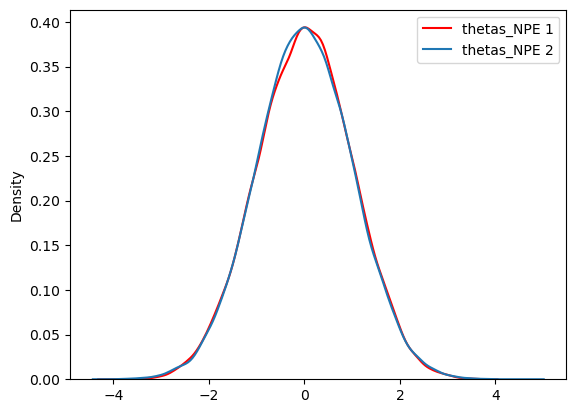

In [61]:
import seaborn as sns
sns.kdeplot(thetas_NPE.squeeze().detach().numpy(),color='red', label='thetas_NPE 1')
sns.kdeplot(np.load("/home/tux/rnpe/thetas_NPE.npy"),color='blue', label='thetas_NPE 2')

plt.legend()
plt.show()

In [62]:
y_raw.mean(0)

tensor([50.0035,  0.9945])

Les thetasm directement

In [63]:
file = np.load("/home/tux/rnpe/robust_samples_paper.npy", allow_pickle=True)
compare(q_NPE,xm_samples,file)

0.9817818181818182

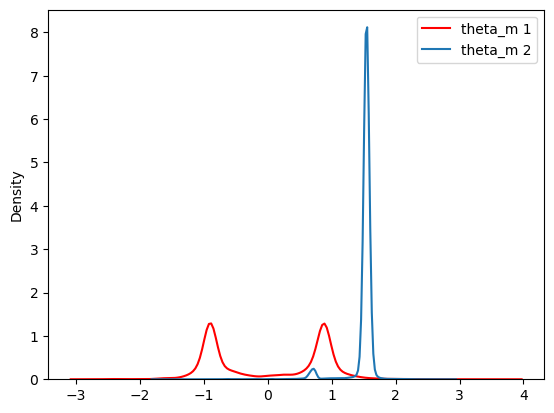

In [64]:
sns.kdeplot(thetasm.squeeze().detach().numpy(),c='red', label='theta_m 1')
sns.kdeplot(np.load("/home/tux/rnpe/robust_samples_paper.npy"),label='theta_m 2')

plt.legend()
plt.show()

In [65]:
def proposal(x_curr):
    return x_curr + torch.distributions.Normal(0,1).sample(x_curr.shape)


def f(y0, x): #% to p(x |y0)
    D = x.shape[0]
    
    res = torch.zeros_like(y0)

    
    for j in range(D):
        xj = x[j]
        yj = y0[j]
        zj = torch.distributions.Bernoulli(rho).sample()
        if not zj:
            
            spike_dist =  torch.distributions.Normal(torch.tensor(xj.clone().detach()), torch.tensor(sigma))
            res[j] = torch.exp(spike_dist.log_prob(yj))

            
        else:
            
            slab_dist = torch.distributions.Cauchy(torch.tensor(xj.clone().detach()), torch.tensor(tau))
            res[j] = torch.exp(slab_dist.log_prob(yj))

    return res


def mcmc(x0, warm_up_steps, M):
    x_curr = x0
    my_samples = torch.empty((warm_up_steps+M, x0.shape[0]))
    log_f_x_curr = f(y0, x_curr).log()
    for i in tqdm.tqdm(range(warm_up_steps+M)):
        x_star = proposal(x_curr)
        log_f_x_star = f(y0, x_star).log()

        log_a = log_f_x_star - log_f_x_curr

        a = torch.exp(log_a)

    
        u = torch.rand(a.shape).to(a)

        mask = u < a

        x_curr = torch.where(mask, x_star, x_curr)
        log_f_x_curr = torch.where(mask, log_f_x_star, log_f_x_curr)
    
        my_samples[i] = x_curr
    my_samples = my_samples[warm_up_steps:]
    return my_samples

my_samples = mcmc(torch.zeros_like(x[0]), warm_up_steps, M)

/tmp/ipykernel_21092/3000667533.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  slab_dist = torch.distributions.Cauchy(torch.tensor(xj.clone().detach()), torch.tensor(tau))
/tmp/ipykernel_21092/3000667533.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spike_dist =  torch.distributions.Normal(torch.tensor(xj.clone().detach()), torch.tensor(sigma))
100%|██████████| 120000/120000 [00:47<00:00, 2533.84it/s]


In [66]:
my_samples_unscaled = (my_samples + x_mean) *x_std
thetas_m = q_NPE.sample(my_samples)

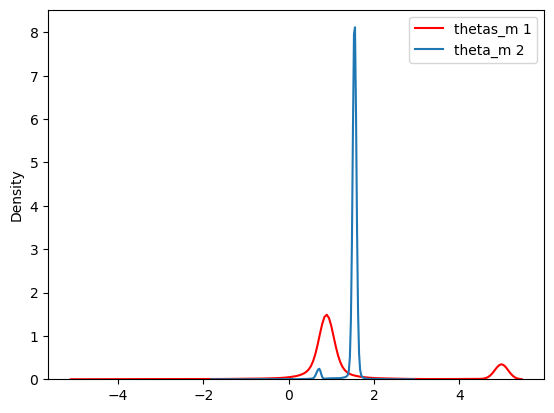

In [67]:
sns.kdeplot(thetas_m.squeeze().detach().numpy(),c='red',label='thetas_m 1')
sns.kdeplot(np.load("/home/tux/rnpe/robust_samples_paper.npy"),label='theta_m 2',c='blue')

plt.legend()
plt.show()

In [68]:
compare(q_NPE,my_samples,file)

0.9067272727272727

In [69]:
file_xm = np.load("/home/tux/rnpe/denoise_xm_paper.npy")
xm_tensor = torch.Tensor(file_xm)
compare(q_NPE, xm_tensor, file)

0.9083636363636364

In [70]:
def compare_xm(my_xm, xm_paper):
    class1 = xm_paper
    class0 = my_xm.detach().numpy()
    class0_labels = np.zeros(len(class0))
    class1_labels = np.ones(len(class1))
    data = np.concatenate((class0,class1), axis=0)
    labels = np.concatenate((class0_labels, class1_labels), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(data,labels)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test,y_pred)
    return acc

compare_xm(xm_samples,file_xm)

0.87632

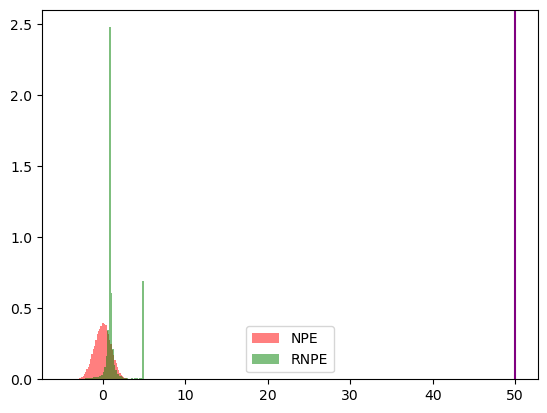

In [71]:
def plot_thetas(thetas_NPE, thetasm):
    n_bins= 50
    plt.hist(thetas_NPE.squeeze().detach().numpy(),bins=n_bins, alpha=0.5, color='r', label='NPE', density=True)
    plt.hist(thetasm.squeeze().detach().numpy(),bins=n_bins, alpha = 0.5, color='g', label='RNPE', density=True)
    plt.axvline(x=mu,color="purple")
    plt.legend()
    plt.show()

plot_thetas(thetas_NPE, thetas_m)

In [72]:
def plot_log_probs(flow, x, y, theta_star):
    
    with torch.no_grad():
        log_probs_NPE = [flow.flow(xj).log_prob(theta_star) for xj in tqdm.tqdm(x)]
        
        log_probs_RNPE = [flow.flow(xmj).log_prob(theta_star) for xmj in tqdm.tqdm(xm_samples)]
        
    fig, ax = plt.subplot()
    ax.boxplot([log_probs_NPE, log_probs_RNPE])
    return log_probs_NPE, log_probs_RNPE

theta_star = torch.tensor(mu).unsqueeze(0)
plot_log_probs(q_NPE, x, y, theta_star)

 76%|███████▌  | 75975/100000 [06:28<02:25, 165.58it/s]

KeyboardInterrupt: 

Sample theta ~q(theta | xm), m = 1, ..., M

In [ ]:
from lampe.diagnostics import expected_coverage_mc, expected_coverage_ni
from lampe.plots import nice_rc, coverage_plot

thetas_star_npe = theta_star.expand(x.shape[0])
dataset_npe = lampe.data.JointDataset(thetas_star_npe.unsqueeze(1),x)

thetas_star_rnpe = theta_star.expand(xm_samples.shape[0])
dataset_rnpe = lampe.data.JointDataset(thetas_star_rnpe, xm_samples)

npe_levels, npe_coverages = expected_coverage_mc(q_NPE.flow, dataset_npe)
nnpe_levels, nnpe_coverages = expected_coverage_mc(q_NPE.flow, dataset_rnpe)

fig = coverage_plot(npe_levels, npe_coverages, legend='NPE')
fig = coverage_plot(nnpe_levels, nnpe_coverages, legend='NNPE')


 66%|██████▌   | 66109/100000 [07:46<03:59, 141.75it/s]







































































































































































































































































































































































































  3%|▎         | 1589/50000 [00:46<23:47, 33.92pair/s]


KeyboardInterrupt: 

Il faut aussi faire les 2 autres simu cad NPE (comme avant) et en mettant directement le modele d'erreur dans le simu